# 06. PyTorch Transfer Learning

> **Note:** This notebook uses `torchvision`'s new [multi-weight support API (available in `torchvision` v0.13+)](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/).

We've built a few models by hand so far.

But their performance has been poor.

You might be thinking, **is there a well-performing model that already exists for our problem?**

And in the world of deep learning, the answer is often *yes*.

We'll see how by using a powerful technique called [**transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning).

In [86]:
import torch
import torchvision
print(torchvision.__version__)
print(torch.__version__)

0.21.0+cu124
2.6.0+cu124


In [87]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [88]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [89]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [90]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [91]:
from going_modular.going_modular import data_setup
from torchvision import transforms

In [92]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [93]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [94]:
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=manual_transforms,
                                                                           batch_size=32
                                                                        )

In [95]:
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x79013a5ad790>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As previously stated, when using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Above we saw how to manually create a transform for a pretrained model.

But as of `torchvision` v0.13+, an automatic transform creation feature has been added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:
    
```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

Where,
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many different model architecture options in `torchvision.models`).
* `DEFAULT` means the *best available* weights (the best performance in ImageNet).
    * **Note:** Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2` where generally the higher version number the better. Though if you want the best available, `DEFAULT` is the easiest option. See the [`torchvision.models` documentation](https://pytorch.org/vision/main/models.html) for more.
    
Let's try it out.

In [96]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [97]:
auto_transforms=weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [98]:
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=auto_transforms,
                                                                           batch_size=32
                                                                        )

In [99]:
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x790139367b10>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

Alright, here comes the fun part!

Over the past few notebooks we've been building PyTorch neural networks from scratch.

And while that's a good skill to have, our models haven't been performing as well as we'd like.

That's where **transfer learning** comes in.

The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customise it to your use case**.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... |
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` |
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... |
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... |
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` |

We want lowest number of parameters and best performance from a pretrained model

In [100]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [101]:
model=torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [102]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [103]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [104]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

To learn more about our model, let's use `torchinfo`'s [`summary()` method](https://github.com/TylerYep/torchinfo#documentation).

To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though [other variants of `efficientnet_bX` have different input sizes](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93).
    * **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `summary()` or your models.
 * `col_names` - the various information columns we'd like to see about our model.
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [105]:
from torchinfo import summary
summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnet-changing-the-classifier-head.png" alt="changing the efficientnet classifier head to a custom number of outputs" width=900/>

*You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original `torchvision.models.efficientnet_b0()` comes with `out_features=1000` because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need `out_features=3`.*

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0` model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [106]:


# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze specific layers (e.g., last N layers or classifier)
unfreeze_layers = ['features.7', 'features.8', 'classifier']  # Example: last 2 blocks + classifier
for name, param in model.named_parameters():
    if any(layer in name for layer in unfreeze_layers):
        param.requires_grad = True  # Unfreeze

# Verify unfrozen layers (optional)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

# Modify classifier head (for 3 classes: sushi, steak, pizza)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 3)




Trainable: features.7.0.block.0.0.weight
Trainable: features.7.0.block.0.1.weight
Trainable: features.7.0.block.0.1.bias
Trainable: features.7.0.block.1.0.weight
Trainable: features.7.0.block.1.1.weight
Trainable: features.7.0.block.1.1.bias
Trainable: features.7.0.block.2.fc1.weight
Trainable: features.7.0.block.2.fc1.bias
Trainable: features.7.0.block.2.fc2.weight
Trainable: features.7.0.block.2.fc2.bias
Trainable: features.7.0.block.3.0.weight
Trainable: features.7.0.block.3.1.weight
Trainable: features.7.0.block.3.1.bias
Trainable: features.8.0.weight
Trainable: features.8.1.weight
Trainable: features.8.1.bias
Trainable: classifier.1.weight
Trainable: classifier.1.bias


In [107]:
from torchinfo import summary
summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   Partial
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1,

In [108]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [109]:
#Update the classifier head to suit our problem
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(class_names),bias=True)
).to(device)

In [110]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

In [111]:
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as timer
start_time=timer()
results=engine.train(model,
                     train_dataloader,
                     test_dataloader,

                     optimizer,
                     loss_fn,
                     5,
                     device)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8967 | train_acc: 0.6133 | test_loss: 0.4601 | test_acc: 0.8580
Epoch: 2 | train_loss: 0.3031 | train_acc: 0.9805 | test_loss: 0.2255 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.1401 | train_acc: 0.9844 | test_loss: 0.2458 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.2987 | train_acc: 0.8711 | test_loss: 0.1806 | test_acc: 0.9479
Epoch: 5 | train_loss: 0.0902 | train_acc: 1.0000 | test_loss: 0.2000 | test_acc: 0.9384
Total training time: 12.211 seconds


In [112]:
import matplotlib.pyplot as plt # Import matplotlib

def plot_loss_curves(results):

  plt.figure(figsize=(15,7))
  epochs=range(len(results["train_loss"]))



  plt.subplot(1,2,1)
  plt.plot(epochs,results["train_loss"],label="train_loss")
  plt.plot(epochs,results['test_loss'],label="test_loss")
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()


  plt.subplot(1,2,2)
  plt.plot(epochs,results["train_acc"],label="train_accuracy")
  plt.plot(epochs,results["test_acc"],label="test_accuracy")
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend();
  plt.show()

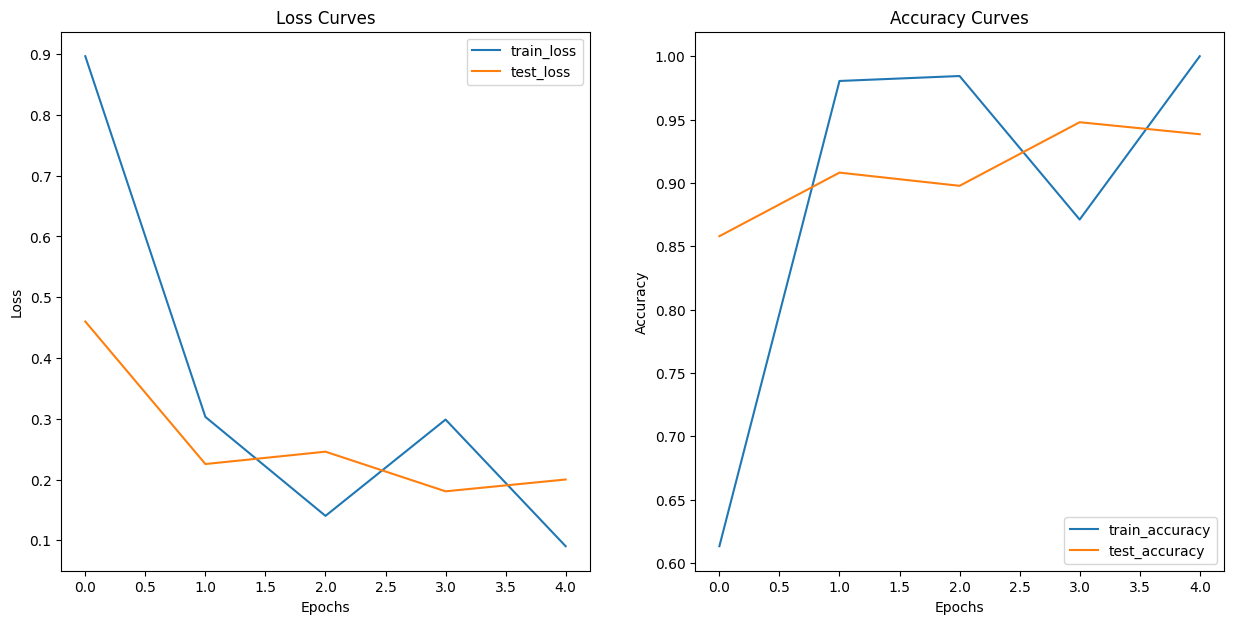

In [113]:
plot_loss_curves(results)

## 6. Make predictions on images from the test set

It looks like our model performs well quantitatively but how about qualitatively?

Let's find out by making some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

*Visualize, visualize, visualize!*

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make predictions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

> **Note:** This is a similar function to [04. PyTorch Custom Datasets section 11.3's](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function) `pred_and_plot_image()` with a few tweaked steps.

In [114]:
from PIL import Image
def final_predictions(model,image_path,class_names,device,transform=None):
  img=Image.open(str(image_path))
  if transforms is not None:
    image_transform=transform
  else:
    image_transform=transforms.Compose([transforms.Resize(224,224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229,0.224,0.225])])


  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image=image_transform(img).unsqueeze(dim=0)

    target_pred_logits=model(transformed_image.to(device))

  target_pred_probs=torch.softmax(target_pred_logits,dim=1)
  target_pred_labels=torch.argmax(target_pred_probs,dim=1)
  #Plot Image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  title = f"Pred: {class_names[target_pred_labels.cpu()]} | Prob: {target_pred_probs.max().cpu():.3f}"
  plt.title(title)


  plt.axis(False);

In [115]:
image_path

PosixPath('data/pizza_steak_sushi')

In [116]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

In [117]:

import pathlib
image_path_list=list(pathlib.Path(test_dir).glob("*/*.jpg"))
image_path_list

[PosixPath('data/pizza_steak_sushi/test/sushi/887831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1742201.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/719108.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/858157.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3806282.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2715127.jpg'),
 PosixPath('data/pizza_steak_s

In [118]:
import random
# random.seed(42)
random_image_path=random.choice(image_path_list)
random_image_path

PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg')

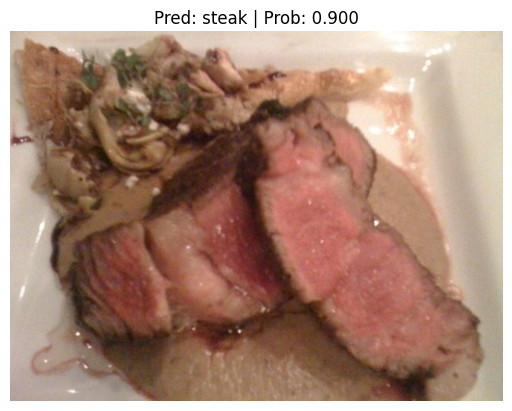

In [119]:
final_predictions(model,random_image_path,class_names,device,auto_transforms)

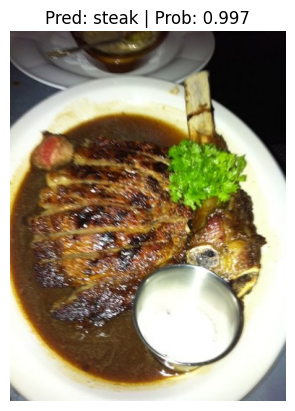

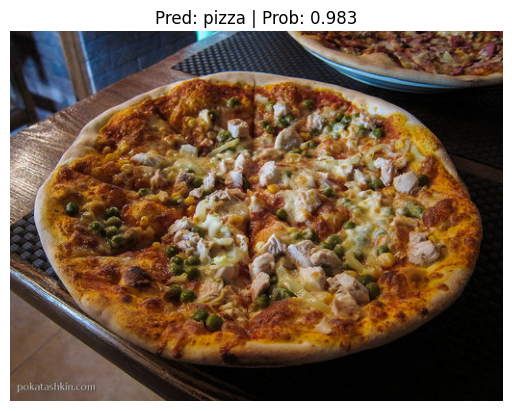

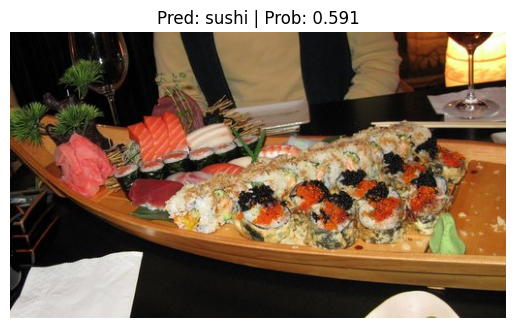

In [120]:
test_image_path_list=random.sample(image_path_list,k=3)
for image_path in test_image_path_list:
  final_predictions(model,image_path,class_names,device,auto_transforms)

In [121]:
import requests
custom_image_path=data_path/"custom_image.jpg"
if not custom_image_path.exists():
  with open(custom_image_path,"wb") as f:
    request=requests.get("https://content.jdmagicbox.com/comp/kolkata/d3/033pxx33.xx33.180131140021.l2d3/catalogue/aajisai-ballygunge-kolkata-restaurants-pdsug.jpg")
    f.write(request.content)
    print("Image downloading")
else:
  print("Image already exists")


Image already exists


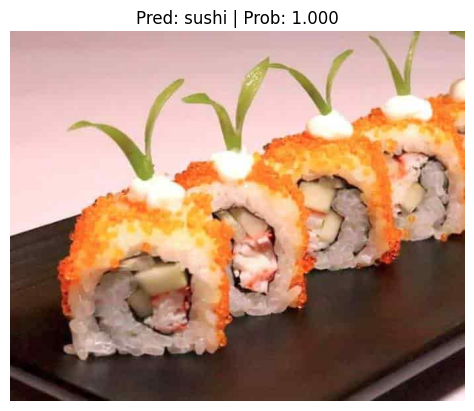

In [122]:
final_predictions(model,custom_image_path,class_names,device,auto_transforms)

In [123]:

import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from tqdm.auto import tqdm
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import os

def evaluate_model(model: torch.nn.Module,
                   test_data_path: str,
                   transform: transforms.Compose,
                   batch_size: int,
                   device: torch.device,
                   num_classes: int = None) -> dict:
    """
    Evaluates a PyTorch model using Accuracy, Precision, Recall, and F1-score.

    Args:
        model: PyTorch model to evaluate
        test_data_path: Path to the test data directory
        transform: PyTorch transform to apply to the test data
        batch_size: Batch size for the data loader
        device: Device to run evaluation on ("cuda" or "cpu")
        num_classes: Number of classes (needed for multiclass metrics)

    Returns:
        Dictionary containing evaluation metrics
    """
    # Set model to evaluation mode
    test_data=datasets.ImageFolder(test_data_path, transform=transform,target_transform=None)
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=os.cpu_count(),
      pin_memory=True,
  )
    model.eval()

    # Initialize lists to store true and predicted labels
    y_true = []
    y_pred = []

    # Disable gradient calculation
    with torch.inference_mode():
        # Loop through batches
        for X, y in tqdm(test_dataloader, desc="Evaluating"):
            # Send data to device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_logits = model(X)

            y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

            # Store labels
            y_true.extend(y.cpu().numpy())
            y_pred.extend(y_pred_class.cpu().numpy())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='macro' if num_classes > 2 else 'binary', zero_division=0),
        "recall": recall_score(y_true, y_pred, average='macro' if num_classes > 2 else 'binary', zero_division=0),
        "f1": f1_score(y_true, y_pred, average='macro' if num_classes > 2 else 'binary', zero_division=0)
    }

    return metrics

def print_metrics(metrics: dict):
    """
    Prints the evaluation metrics.

    Args:
        metrics: Dictionary containing evaluation metrics
    """
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")



In [127]:
from going_modular.going_modular import utils
metrics=evaluate_model(model,test_dir,auto_transforms,32,device,num_classes=len(class_names))
print_metrics(metrics)
utils.save_model(model,"models","FoodVisionMINI.pth")

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy: 0.9467
Precision: 0.9413
Recall: 0.9476
F1-score: 0.9435
[INFO] Saving model to: models/FoodVisionMINI.pth
